## Exploratory Data Analysis - Anti Cancer Peptides

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from scipy.stats import pearsonr
import os

import sys  
sys.path.insert(0, '../scripts')

import eda_utils as eda

%matplotlib inline

Allow multiple outputs from each cell.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load in train and test datasets.

In [3]:
df_train = pd.read_csv("../data/acp/train_data.csv")
df_test = pd.read_csv("../data/acp/test_data.csv")

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

train_per = round(100*(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])))
print(f"Train-test split: {train_per}% Train, {100-train_per}% Test")

Train dataset shape: (1378, 2)
Test dataset shape: (344, 2)
Train-test split: 80% Train, 20% Test


Take a look at the format of the data.

In [4]:
df_train.head()
df_train.dtypes
print(f"Unique values of label: {df_train.label.unique()}")

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


sequences    object
label         int64
dtype: object

Unique values of label: [0 1]


Check for distribution of classes to identify potential imbalances.

In [5]:
df_train.label.value_counts()
df_test.label.value_counts()
print("Both train and test datasets are perfectly balanced between the positive and negative class")

0    689
1    689
Name: label, dtype: int64

0    172
1    172
Name: label, dtype: int64

Both train and test datasets are perfectly balanced between the positive and negative class


Check if any leading or trailing white spaces present in sequences

In [6]:
len_train = df_train.sequences.apply(len)
len_train_2 = df_train.sequences.str.strip().apply(len)

len_test = df_test.sequences.apply(len)
len_test_2 = df_test.sequences.str.strip().apply(len)

In [7]:
np.where(len_train != len_train_2)
np.where(len_test != len_test_2)

(array([], dtype=int64),)

(array([], dtype=int64),)

No white spaces present in sequences

### Sequence Sizes

Visualizing the distribution of the lengths of sequences in each dataset.

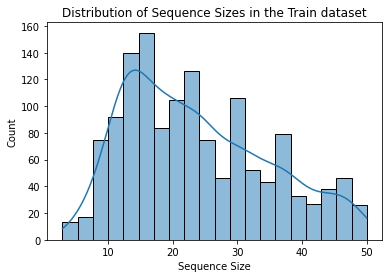

In [8]:
sns.histplot(df_train.sequences.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Train dataset');

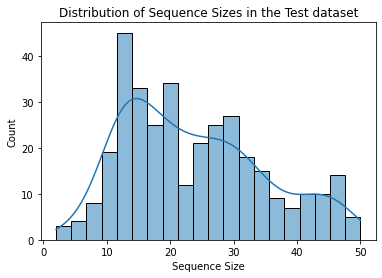

In [9]:
sns.histplot(df_test.sequences.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Test dataset');

In [10]:
train_seq_sizes = df_train.sequences.str.len()
test_seq_sizes = df_test.sequences.str.len()

print(f"Train dataset - mean of sequence sizes: {train_seq_sizes.mean()}")
print(f"Test dataset - mean of sequence sizes: {test_seq_sizes.mean()}")

print(f"Train dataset - smallest sequence size: {train_seq_sizes.min()}")
print(f"Test dataset - smallest sequence size: {test_seq_sizes.min()}")

print(f"Train dataset - largest sequence size: {train_seq_sizes.max()}")
print(f"Test dataset - largest sequence size: {test_seq_sizes.max()}")

Train dataset - mean of sequence sizes: 23.826560232220608
Test dataset - mean of sequence sizes: 23.75872093023256
Train dataset - smallest sequence size: 3
Test dataset - smallest sequence size: 2
Train dataset - largest sequence size: 50
Test dataset - largest sequence size: 50


### Checking distribution of sequence sizes between each label

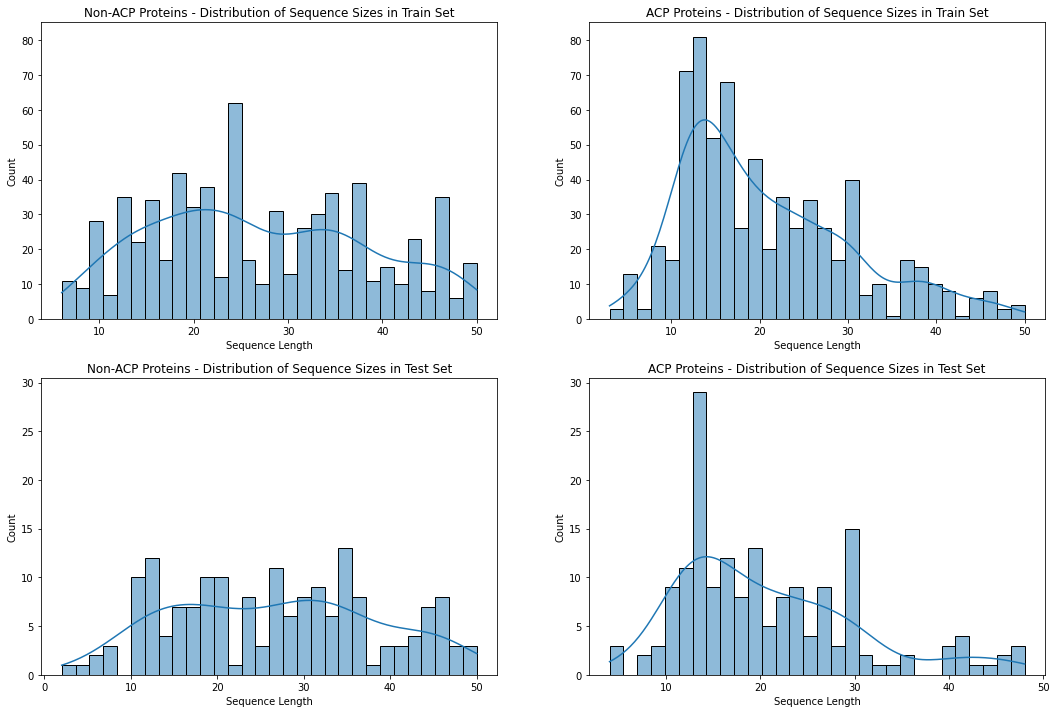

In [52]:
plt.figure(figsize=(18,12))

ax1 = plt.subplot(221)
sns.histplot(df_train[df_train.label==0].sequences.str.len(), bins=30, kde=True).set(
                title='Non-ACP Proteins - Distribution of Sequence Sizes in Train Set');
ax1.set(xlabel='Sequence Length', ylabel='Count');

ax2 = plt.subplot(222, sharey=ax1)
sns.histplot(df_train[df_train.label==1].sequences.str.len(), bins=30, kde=True).set(
                title='ACP Proteins - Distribution of Sequence Sizes in Train Set');
ax2.set(xlabel='Sequence Length', ylabel='Count');

ax3 = plt.subplot(223)
sns.histplot(df_test[df_test.label==0].sequences.str.len(), bins=30, kde=True).set(
                title='Non-ACP Proteins - Distribution of Sequence Sizes in Test Set');
ax3.set(xlabel='Sequence Length', ylabel='Count');

ax4 = plt.subplot(224, sharey=ax3)
sns.histplot(df_test[df_test.label==1].sequences.str.len(), bins=30, kde=True).set(
                title='ACP Proteins - Distribution of Sequence Sizes in Test Set');
ax4.set(xlabel='Sequence Length', ylabel='Count');

In [12]:
summary_df = pd.concat([df_train["sequences"].str.len(), df_train.label], axis=1).groupby("label").agg(['mean', 'min', 'max'])
summary_df.columns = summary_df.columns.set_levels(['Train set sequences'],level=0)

summary_df2 = pd.concat([df_test["sequences"].str.len(), df_test.label], axis=1).groupby("label").agg(['mean', 'min', 'max'])
summary_df2.columns = summary_df2.columns.set_levels(['Test set sequences'],level=0)

pd.concat([summary_df, summary_df2], axis=1)

Train set sequences         Test set sequences        
                     mean min max               mean min max
label                                                       
0               26.969521   6  50          26.720930   2  50
1               20.683599   3  50          20.796512   4  48

It looks like there is a significant difference in the distribution of sequence lengths between DBP and non-DBP proteins, so this feature could have a moderate level of predictive power.

This [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC137605/) supports the idea of length as a potential indicator of protein function, so we will include it during our feature engineering step.

### Checking for Duplicates

Making sure there are no duplicate proteins.

In [13]:
df_train.sequences.duplicated().sum()
df_test.sequences.duplicated().sum()

0

0

## Feature Engineering - Protein Features

Confirm that 20 amino acids are present in our sequences.

In [14]:
amino_acids = set()
for protein in df_train.sequences:
    for acid in protein:
        amino_acids.add(acid)
print(amino_acids)
print(len(amino_acids))

{'D', 'F', 'C', 'M', 'Y', 'E', 'H', 'R', 'T', 'S', 'V', 'Q', 'I', 'A', 'L', 'G', 'W', 'N', 'K', 'P'}
20


In [15]:
# Add protein features as columns
df_train = eda.add_protein_features(df_train, "sequences")
df_test = eda.add_protein_features(df_test, "sequences")

In [16]:
df_train.head()

,sequences,label,length,amino_acid_count,amino_acid_percent,aromaticity,isoelectric_point,charge_at_pH,molecular_weight,instability_index,flexibility,gravy,helix_frac,turn_frac,sheet_frac,molar_extinction_coefficient
0,RRWWRRWRRW,0,10,"{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...","{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': ...",0.400000,11.999968,5.557302,1699.9691,352.680000,0.967143,-3.060000,0.400000,0.000000,0.000000,22000.0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,26,"{'A': 2, 'C': 0, 'D': 1, 'E': 0, 'F': 1, 'G': ...","{'A': 7.6923076923076925, 'C': 0.0, 'D': 3.846...",0.115385,10.295295,4.579467,2816.3054,22.946154,1.011433,-0.230769,0.346154,0.230769,0.192308,6990.0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,34,"{'A': 8, 'C': 0, 'D': 1, 'E': 0, 'F': 0, 'G': ...","{'A': 23.52941176470588, 'C': 0.0, 'D': 2.9411...",0.029412,10.001706,2.634853,3455.0584,1.847059,0.998206,0.185294,0.205882,0.147059,0.441176,5500.0
3,GLFDVIKKVAAVIGGL,1,16,"{'A': 2, 'C': 0, 'D': 1, 'E': 0, 'F': 1, 'G': ...","{'A': 12.5, 'C': 0.0, 'D': 6.25, 'E': 0.0, 'F'...",0.062500,8.590944,0.552888,1599.9542,14.187500,0.994602,1.443750,0.500000,0.187500,0.250000,0.0
4,VAKLLAKLAKKVL,1,13,"{'A': 3, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...","{'A': 23.076923076923077, 'C': 0.0, 'D': 0.0, ...",0.000000,10.477676,3.513128,1394.8306,-10.361538,1.003571,1.030769,0.461538,0.000000,0.538462,0.0


In [17]:
df_train.dtypes

sequences                        object
label                             int64
length                            int64
amino_acid_count                 object
amino_acid_percent               object
aromaticity                     float64
isoelectric_point               float64
charge_at_pH                    float64
molecular_weight                float64
instability_index               float64
flexibility                     float64
gravy                           float64
helix_frac                      float64
turn_frac                       float64
sheet_frac                      float64
molar_extinction_coefficient    float64
dtype: object

### Amino Acid Frequencies/Composition

#### Get average amino acid content of sequences

In [18]:
acp_avg_acids = eda.get_avg_amino_acid_count(df_train[df_train.label==1], amino_acids)
non_acp_avg_acids = eda.get_avg_amino_acid_count(df_train[df_train.label==0], amino_acids)

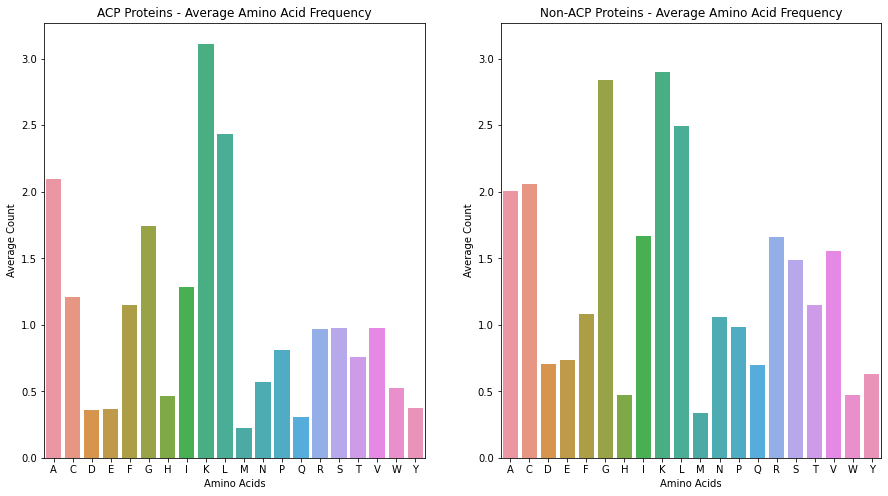

In [19]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
sns.barplot(x = sorted(acp_avg_acids.keys()), 
            y = [acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())]).set(
                title='ACP Proteins - Average Amino Acid Frequency');
ax1.set(xlabel='Amino Acids', ylabel='Average Count');

ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_acp_avg_acids.keys()), 
            y = [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())]).set(
                title='Non-ACP Proteins - Average Amino Acid Frequency');
ax2.set(xlabel='Amino Acids', ylabel='Average Count');

In [20]:
pearsonr([acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())],
            [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())])[0]

0.9072315508523577

As seen in both the barplots of and correlation between the amino acid average counts of acp and non-acp proteins, there is very little difference between the two, so this feature likely has very little predictive power for classifying ACPs and non-ACPs. 

In addition, the proteins chosen for this dataset may not be indicative of general trends in amino acid frequency, so we have to take care to be aware of this assumption if using this feature in our models.

#### Get average percentage of amino acids for each sequence

In [21]:
# Get average percentage of frequency of each amino acid over all ACP and non-ACP sequences
acp_avg_acids_percent = eda.get_avg_amino_acid_percent(df_train[df_train.label==1], amino_acids)
non_acp_avg_acids_percent = eda.get_avg_amino_acid_percent(df_train[df_train.label==0], amino_acids)

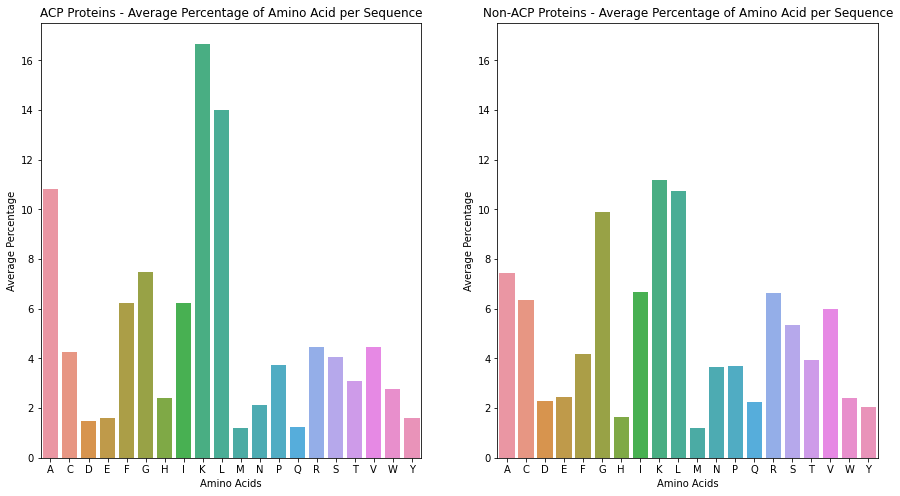

In [22]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(121)
sns.barplot(x = sorted(acp_avg_acids_percent.keys()), 
            y = [acp_avg_acids_percent.get(key) for key in sorted(acp_avg_acids_percent.keys())]).set(
                title='ACP Proteins - Average Percentage of Amino Acid per Sequence');
ax1.set(xlabel='Amino Acids', ylabel='Average Percentage');
ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_acp_avg_acids_percent.keys()), 
            y = [non_acp_avg_acids_percent.get(key) for key in sorted(non_acp_avg_acids_percent.keys())]).set(
                title='Non-ACP Proteins - Average Percentage of Amino Acid per Sequence');
ax2.set(xlabel='Amino Acids', ylabel='Average Percentage');


In [23]:
pearsonr([acp_avg_acids_percent.get(key) for key in sorted(acp_avg_acids_percent.keys())],
            [non_acp_avg_acids_percent.get(key) for key in sorted(non_acp_avg_acids_percent.keys())])[0]

0.89539681075909

As seen in both the barplots of and correlation between the amino acid average percentages per sequence of acp and non-acp proteins, there is very little difference between the two, so this feature likely has very little predictive power for classifying ACPs and non-ACPs. 

In addition, the proteins chosen for this dataset may not be indicative of general trends in amino acid frequency, so we have to take care to be aware of this assumption if using this feature in our models.

### All other Protein Features

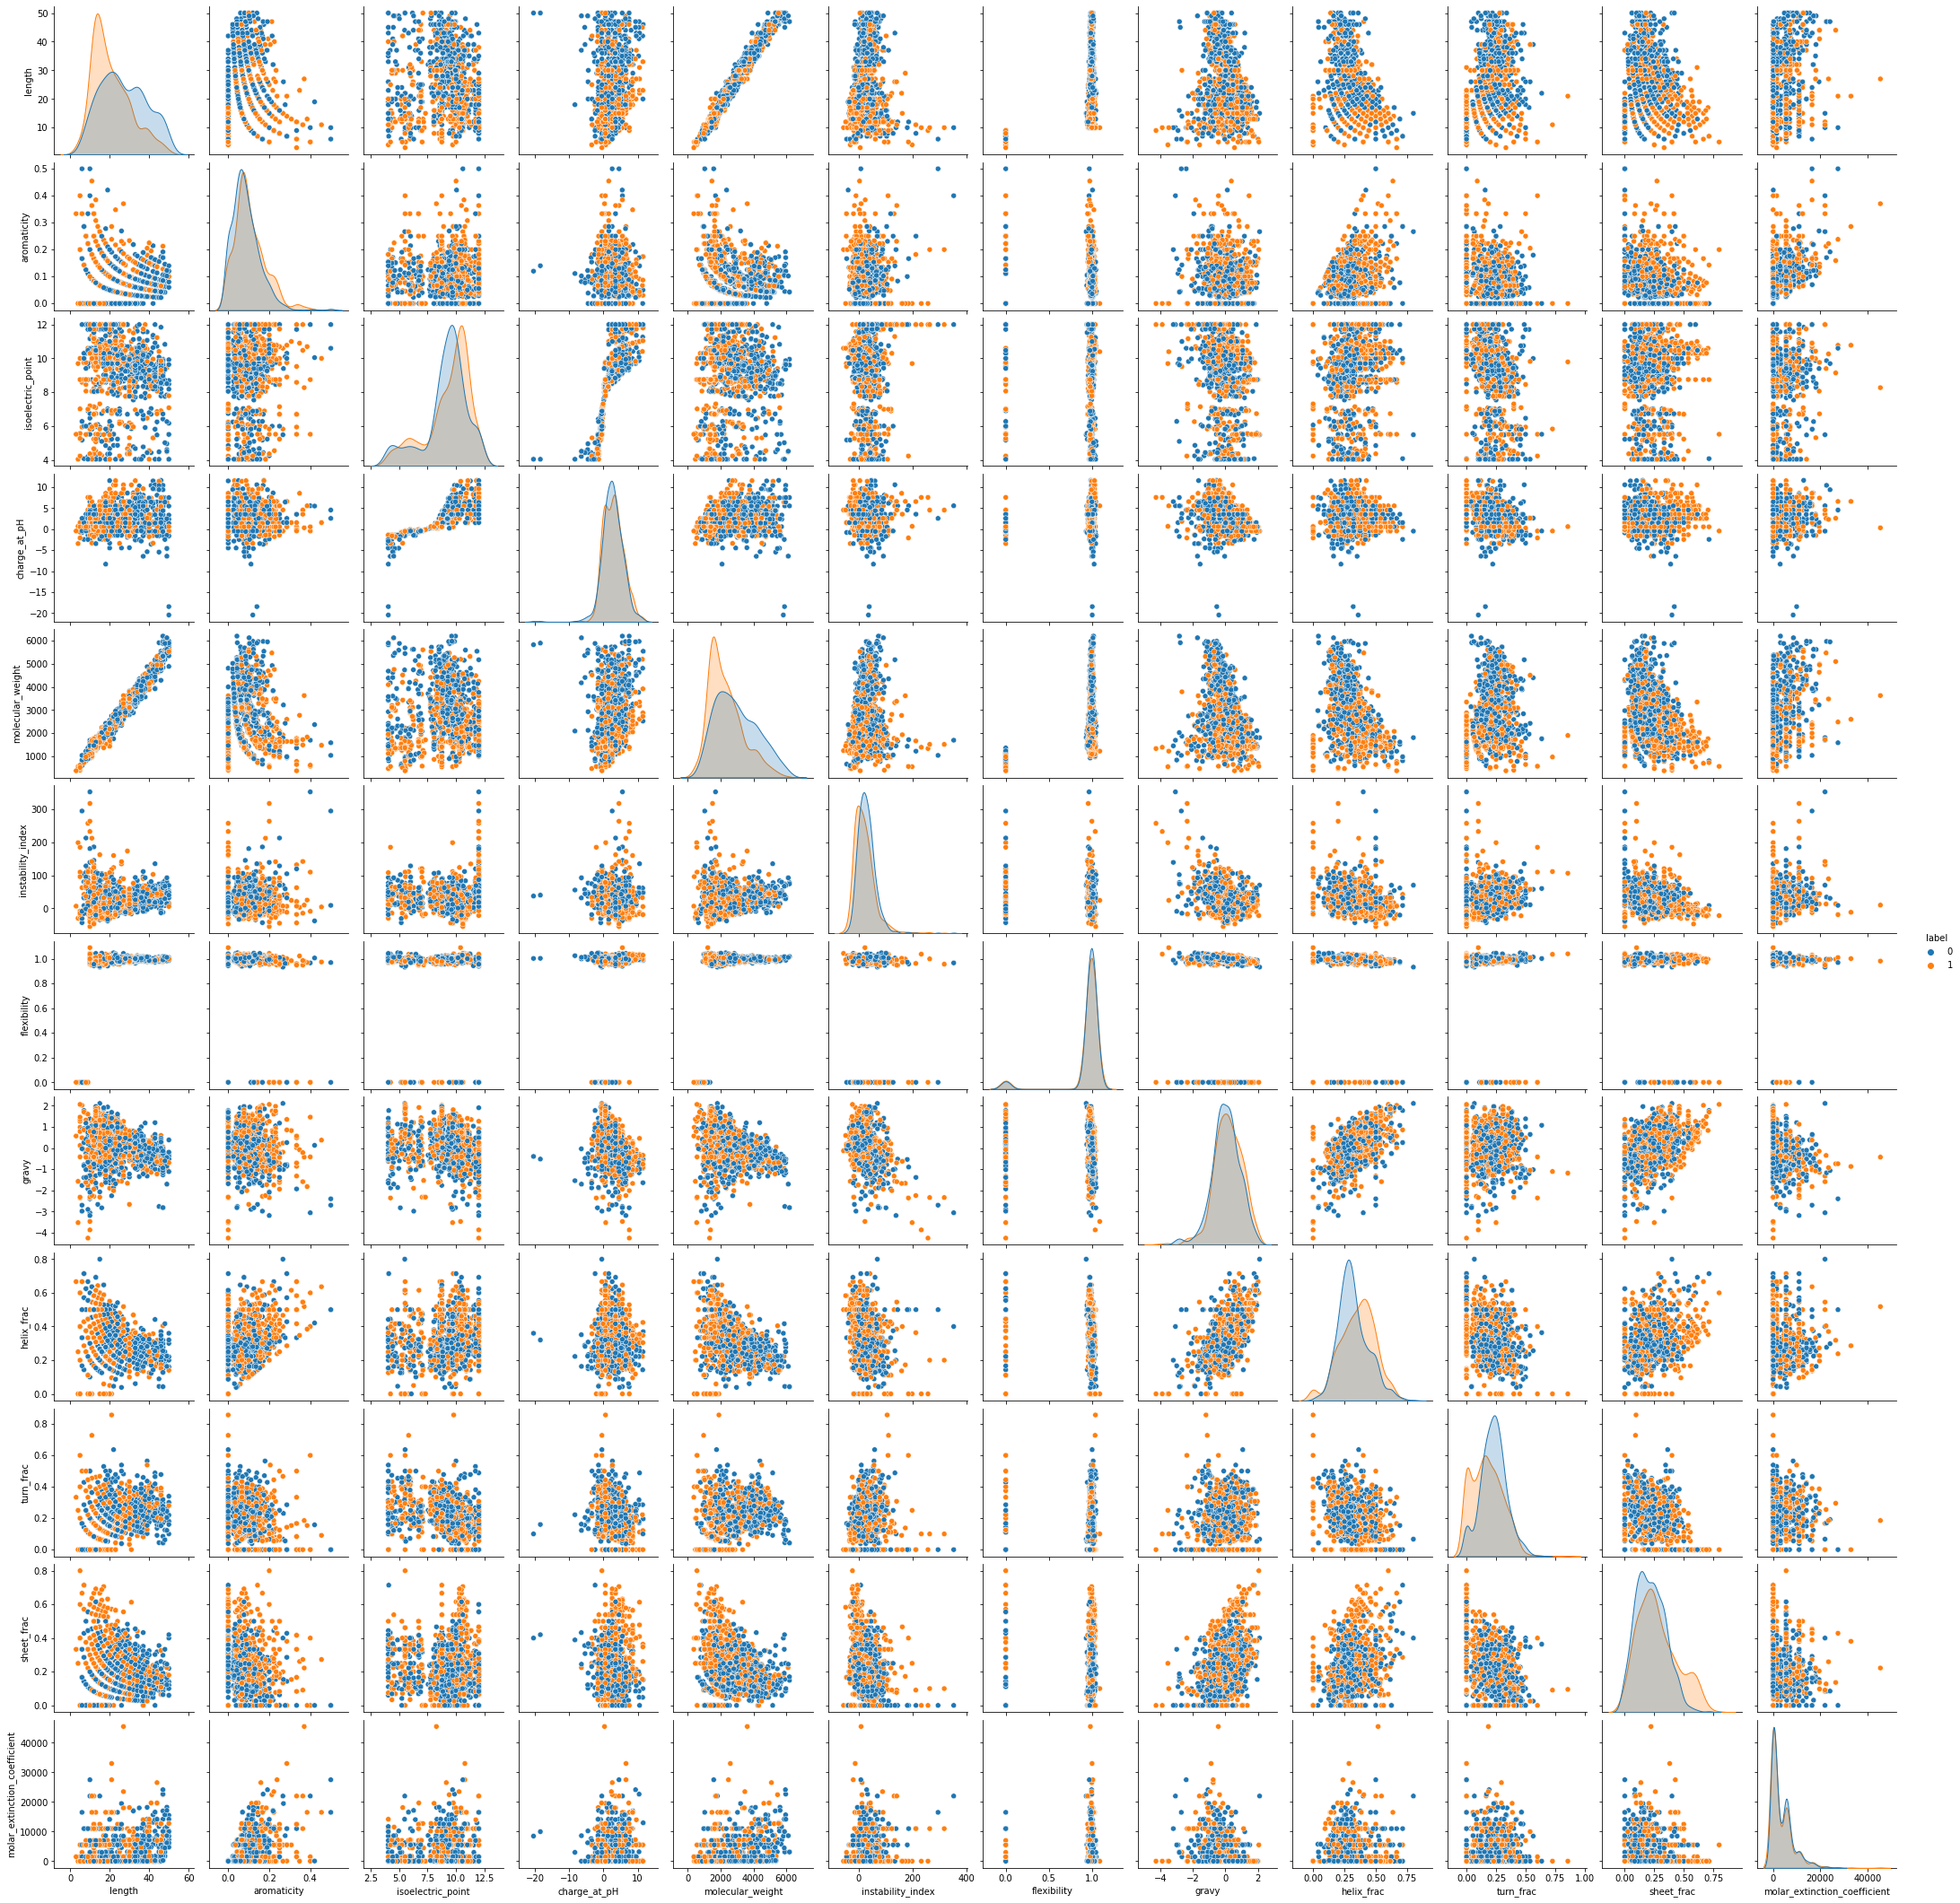

In [50]:
prot_features = ['length', 'aromaticity', 'isoelectric_point', 'charge_at_pH', 'molecular_weight', 'instability_index', 
 'flexibility', 'gravy', 'helix_frac', 'turn_frac', 'sheet_frac', 'molar_extinction_coefficient']
sns.pairplot(data=df_train, x_vars=prot_features, hue="label")

While there seems to be some separation between ACPs and non-ACPs with regards to these features, the two groups are not well separated by any of these features. It is possible however that a classifier that uses all of these features might perform well.

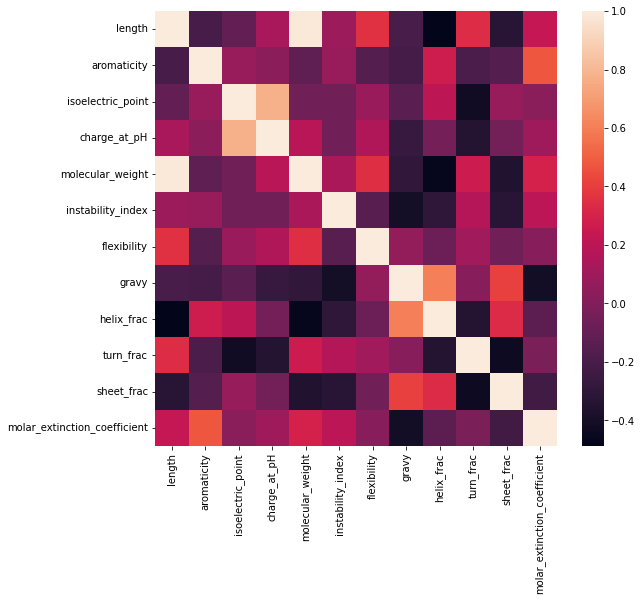

In [51]:
plt.figure(figsize=(9,8))
sns.heatmap(data=df_train[prot_features].corr());

It looks like `length` and `molecular_weight` are fully correlated, which makes sense given that adding amino acids to a sequence increases both length and molecular weight every time.

It looks like the only other highly correlated features are `charge_at_pH` and `isoelectric_point`. This makes sense, as both refer to a pH value, the first being the charge of the protein at the average human body pH (7.4), and the second as the pH at which no net migration takes place in an electric field.

Since these sets of features are highly correlated, it might be a good idea to remove one of them from each during modelling to avoid multicollinearity, especially one of the two fully correlated features, after checking the variance inflation factor to quantify the severity of multicollinearity. 

In [26]:
df_train.to_csv("../data/acp/train_expanded.csv", index=False)
df_test.to_csv("../data/acp/test_expanded.csv", index=False)

## Alignment

In [27]:
sequences = df_train.copy()
sequences.drop(df_train.columns.difference(["sequences", "label"]), axis=1, inplace=True)
sequences.head()

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


In [41]:
# Demonstrate pairwise alignment 
for idx, prot_1 in enumerate(sequences.sequences[:3]):
    sim_seq = None
    max_score = 0
    alignment = None
    for prot_2 in sequences.sequences.drop(idx):
        alignments = pairwise2.align.globalxx(prot_1, prot_2)
        score = int(format_alignment(*alignments[0]).split("Score=")[1].rstrip())
        if score > max_score:
            max_score = score
            sim_seq = prot_2
            alignment = format_alignment(*alignments[0])
    print(max_score, sim_seq)
    print(alignment)

8 GRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQA
-RR----W-------------W-R--RW--R--------RW---------
 ||    |             | |  |   |        |          
GRRRSVQWCAVSQPEATKCFQWQRNMR-KVRGPPVSCIKR-DSPIQCIQA
  Score=8

16 GWRTLLKKAEVKTVGKLALKHYL
GWKSVFRKA---KK--VGKTVGG-LALD-HYLG
||    |     ||  | ||| | |||  ||| 
GW----R--TLLKKAEV-KTV-GKLAL-KHYL-
  Score=16

31 ALWKTMLKKLGTVALHAGKAALGAAADTISQGA
ALWKTMLKKLGTM-ALHAGKAALGAAADTISQGTQ-
||||||||||||  |||||||||||||||||||   
ALWKTMLKKLGT-VALHAGKAALGAAADTISQG--A
  Score=31



### Investigating cross-similarity scores

In [29]:
cross_df_tr = pd.DataFrame(index=df_train.sequences, columns=df_train.sequences)
cross_df_tr.head()

cross_df_t = pd.DataFrame(index=df_test.sequences, columns=df_test.sequences)
cross_df_t.head()

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GWKSVFRKAKKVGKTVGGLALDHYLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLFDVIKKVAAVIGGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VAKLLAKLAKKVL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sequences,FLPLLLSALPSFLCLVFKKC,DKLIGSCVWLAVNYTSNCNAECKRRGYKGGHCGSFLNVNCWCET,AVKDTYSCFIMRGKCRHECHDFEKPIGFCTKLNANCYM,GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,ENCGRQAG,GVLDAFRKIATVVKNVV,VAKKFAKKFKKFAKKFAKFAFAF,GIGKFLHSAKKWGKAFVGQIMNC,ALWKNMLKGIGKLAGKAALGAVKKLVGAES,FFPIVGKLLFGLSGLL,...,ILGPVISTIGGVLGGLLKNL,PEWFKCRRWQWRMKKLGA,GFLDTFKNLALNAAKSAGVSVLNSLSCKLFKTC,SGKLWWRRKK,CAHNLTHAC,LLKKLLKWLKK,GLLLDTLKGAAKDIAGIALEKLKCKITGCKP,FWGALAKGALKLIPSLFSSFSKKD,GCLEFWWKCNPNDDKCCRPKLKCSKLFKLCNFSF,FNRGGYNFGKSVRHVVDAIGSVAGILKSIR
sequences,,,,,,,,,,,,,,,,,,,,,
FLPLLLSALPSFLCLVFKKC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DKLIGSCVWLAVNYTSNCNAECKRRGYKGGHCGSFLNVNCWCET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVKDTYSCFIMRGKCRHECHDFEKPIGFCTKLNANCYM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCGRQAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
%%time
# Get cross similarity scores of each pair of sequences
cross_df_tr = cross_df_tr.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))
cross_df_t = cross_df_t.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))

CPU times: user 1min 25s, sys: 11.2 ms, total: 1min 25s
Wall time: 1min 25s


In [31]:
cross_df_tr

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,10.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,...,3.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,4.0
GWKSVFRKAKKVGKTVGGLALDHYLG,2.0,26.0,11.0,9.0,8.0,7.0,5.0,8.0,9.0,1.0,...,10.0,6.0,5.0,14.0,11.0,5.0,10.0,8.0,5.0,4.0
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1.0,11.0,34.0,7.0,9.0,8.0,6.0,8.0,12.0,3.0,...,8.0,7.0,5.0,12.0,14.0,8.0,11.0,10.0,6.0,2.0
GLFDVIKKVAAVIGGL,0.0,9.0,7.0,16.0,6.0,8.0,3.0,5.0,7.0,2.0,...,6.0,5.0,4.0,9.0,10.0,4.0,10.0,5.0,6.0,5.0
VAKLLAKLAKKVL,0.0,8.0,9.0,6.0,13.0,4.0,5.0,6.0,8.0,1.0,...,7.0,6.0,3.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LLKLLKWLLKLLK,1.0,5.0,8.0,4.0,7.0,5.0,6.0,6.0,6.0,1.0,...,6.0,6.0,3.0,7.0,7.0,13.0,5.0,5.0,3.0,1.0
GFKDWIKGAAKKLIKTVAANIANQ,1.0,10.0,11.0,10.0,6.0,7.0,3.0,7.0,9.0,3.0,...,10.0,5.0,5.0,12.0,11.0,5.0,24.0,9.0,6.0,4.0
ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,6.0,8.0,10.0,5.0,4.0,4.0,5.0,5.0,11.0,3.0,...,9.0,6.0,4.0,12.0,7.0,5.0,9.0,49.0,6.0,8.0


Note that the diagonal elements are equal to the length of that sequence.

In [32]:
# Verifying that the cross-similarity matrix is symmetric
cross_np = cross_df_tr.values
np.all(cross_np == cross_np.T)

cross_np = cross_df_t.values
np.all(cross_np == cross_np.T)

True

True

### Normalized cross-similarity matrices

In [58]:
norm_cross_df_tr = cross_df_tr/np.diag(cross_df_tr)
norm_cross_df_t = cross_df_t/np.diag(cross_df_t)

In [59]:
norm_cross_df_tr.head()

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,1.0,0.076923,0.029412,0.0000,0.000000,0.000000,0.076923,0.066667,0.075,0.000000,...,0.130435,0.000000,0.125,0.000000,0.000000,0.076923,0.041667,0.122449,0.000000,0.333333
GWKSVFRKAKKVGKTVGGLALDHYLG,0.2,1.000000,0.323529,0.5625,0.615385,0.466667,0.384615,0.533333,0.225,0.111111,...,0.434783,0.461538,0.625,0.424242,0.392857,0.384615,0.416667,0.163265,0.384615,0.333333
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,0.1,0.423077,1.000000,0.4375,0.692308,0.533333,0.461538,0.533333,0.300,0.333333,...,0.347826,0.538462,0.625,0.363636,0.500000,0.615385,0.458333,0.204082,0.461538,0.166667
GLFDVIKKVAAVIGGL,0.0,0.346154,0.205882,1.0000,0.461538,0.533333,0.230769,0.333333,0.175,0.222222,...,0.260870,0.384615,0.500,0.272727,0.357143,0.307692,0.416667,0.102041,0.461538,0.416667
VAKLLAKLAKKVL,0.0,0.307692,0.264706,0.3750,1.000000,0.266667,0.384615,0.400000,0.200,0.111111,...,0.304348,0.461538,0.375,0.272727,0.285714,0.538462,0.250000,0.081633,0.384615,0.166667


In [60]:
# Verifying normalization performed correctly, diagonals are filled with 1's
assert np.all(np.diag(norm_cross_df_tr) == True)
assert np.all(np.diag(norm_cross_df_t) == True)

In [61]:
# Verifying that normalized matrices are no longer symmetric, due to the different sizes of sequences
assert not (np.all(norm_cross_df_tr != norm_cross_df_tr.T))
assert not (np.all(norm_cross_df_t != norm_cross_df_t.T))

Visualizing distribution of normalized simalirity scores

In [84]:
# Removing 1's from diagonal to not count them in histogram
norm_cross_df_tr_temp = norm_cross_df_tr.copy()
np.fill_diagonal(norm_cross_df_tr_temp.to_numpy(), -1)
norm_arr_tr = np.delete(norm_cross_df_tr_temp.to_numpy().flatten(), np.where(norm_cross_df_tr_temp.to_numpy().flatten() == -1))

norm_cross_df_t_temp = norm_cross_df_t.copy()
np.fill_diagonal(norm_cross_df_t_temp.to_numpy(), -1)
norm_arr_t = np.delete(norm_cross_df_t_temp.to_numpy().flatten(), np.where(norm_cross_df_t_temp.to_numpy().flatten() == -1))

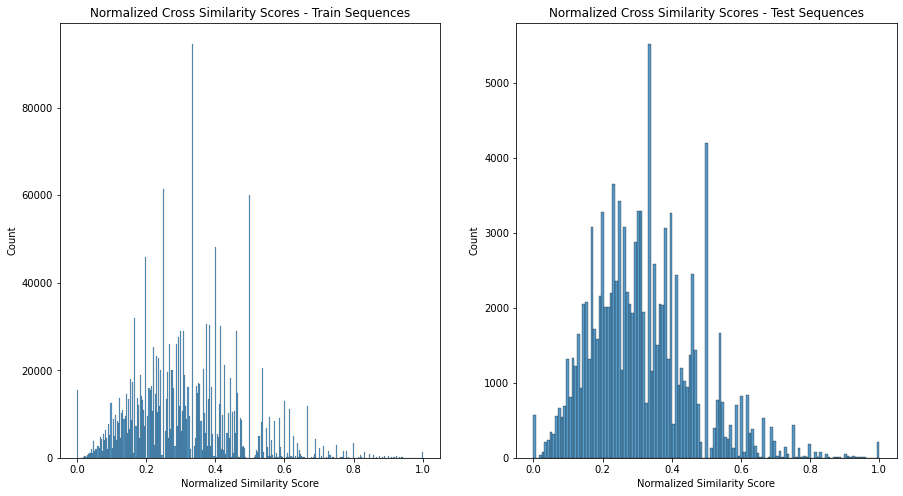

In [85]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
sns.histplot(norm_arr_tr).set(title='Normalized Cross Similarity Scores - Train Sequences');
ax1.set(xlabel='Normalized Similarity Score', ylabel='Count');

ax2 = plt.subplot(122)
sns.histplot(norm_arr_t).set(title='Normalized Cross Similarity Scores - Test Sequences');
ax2.set(xlabel='Normalized Similarity Score', ylabel='Count');

In [86]:
print("Mean similarity score - Train: ", norm_arr_tr.mean())
print("Mean similarity score - Test: ", norm_arr_t.mean())
print("Maximum similarity score - Train: ", norm_arr_tr.max())
print("Maximum similarity score - Test: ", norm_arr_t.max())

Mean similarity score - Train:  0.31342780538008097
Mean similarity score - Test:  0.31633912426667016
Maximum similarity score - Train:  1.0
Maximum similarity score - Test:  1.0


It looks like most sequences share only about a third of their amino acid alignments with other sequences, although there are a number of sequences which are very similar to each other, and some that are a subset of others.

In [40]:
norm_cross_df_tr.to_csv("../data/acp/train_cross_similarity_norm.csv")
norm_cross_df_t.to_csv("../data/acp/test_cross_similarity_norm.csv")